In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import scipy
import pickle

import sys
rootff = ''
sys.path.append(rootff+'/SpeckledFluoImagingAnalisys/')
import speckle_stuffs as spkstf
from moro_utils import printProgressBar, shiftimg

In [9]:
rootfolder = rootff+'/290405_threedaysofconvex/'

seeds = np.unique(['_'.join(ff.split('_')[:-1]) for ff in os.listdir(rootfolder) if ff[:6]=='video_'])
for ss in seeds:
    print(ss)

video_04122018_4045
video_04122018_7674
video_05122018_1900
video_05122018_3474
video_05122018_362
video_05122018_4809
video_05122018_5042
video_29112018_1568
video_29112018_3836
video_29112018_5218
video_29112018_5469
video_29112018_6324


In [3]:
# microns/px in the DMD space
pxum = 7.6 / (20 *(200/165))

def ccorr(sp1, sp2): 
    fft_product = np.multiply(np.fft.fft2(sp1), np.fft.fft2(sp2).conj())
    corr = np.abs(np.fft.fftshift(np.fft.ifft2(fft_product)))
    return corr

def cpeckleccorr(sp1, sp2):
    return np.max(ccorr(sp1, sp2))**2/(np.max(ccorr(sp1, sp1))*np.max(ccorr(sp2, sp2)))

def pt_dist(pt1, pt2):
    return np.sqrt((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)

def crop(img, ratio):
    # take the central part of the image
    img = np.array(img)
    ss = np.shape(img)
    ns = np.multiply(ss, ratio)
    return img[ int(ss[0]/2-ns[0]/2):int(ss[0]/2+ns[0]/2), int(ss[1]/2-ns[1]/2):int(ss[1]/2+ns[1]/2) ]

In [71]:
vsdistance = []

for iii, seed in enumerate(seeds):
    print(seed)
    speklepats = rootfolder+os.sep+seed+'_speckle.tiff'
    botcampat = rootfolder+os.sep+seed+'_bottomcamera.tiff'
    pointlist = rootfolder+os.sep+seed+'_spots.csv'
    points = np.loadtxt(pointlist, delimiter=',')
#     spekles = np.transpose(imread(speklepats), (2,0,1))
    spekles = imread(speklepats)
    dataset = []
    for pt, spk in zip(points, spekles):
        spk = spkstf.gauss_don_filt(matrix=spk, lp=100, hp=5)
        dataset.append([pt, spk])
    
    dslen = len(dataset)
    ccors = np.zeros((dslen, dslen))
    localcorrs = []
    for idx1 in range(dslen):
        for idx2 in range(idx1, dslen):
            printProgressBar((idx1*dslen+idx2)/2+1, (dslen*dslen)/2)
            tmpd = pt_dist(dataset[idx1][0], dataset[idx2][0])*pxum
            ccors[idx1, idx2] = cpeckleccorr(dataset[idx1][1], dataset[idx2][1])
            localcorrs.append([tmpd, ccors[idx1, idx2]])
    vsdistance.append(localcorrs)

video_04122018_4045
 |****************************************************************************************************| : 85/84video_04122018_7674
 |*****************************************************************************************************| : 32/32video_05122018_1900
 |****************************************************************************************************| : 85/84video_05122018_3474
 |*****************************************************************************************************| : 50/50video_05122018_362
 |********************************************************************************************************| : 13/12video_05122018_4809
 |*****************************************************************************************************| : 32/32video_05122018_5042
 |****************************************************************************************************| : 145/144video_29112018_1568
 |*****************************************************

In [72]:
# save pickle for analysis
rndse = int(np.random.rand()*1000)
fname = 'ME_beads_analisys_%d.pickle'%rndse
pickle.dump( vsdistance, open( rootfolder+os.sep+fname, "wb" ) )
print('data saved in %s'%fname)

data saved in ME_beads_analisys_500.pickle


In [5]:
# load pickles for analysis
fname = 'ME_beads_analisys_622.pickle'
vsdistance = pickle.load( open( rootfolder+os.sep+fname, "rb" ) )
# remove the 7th dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add


9.684063008431561 344.2166941157226


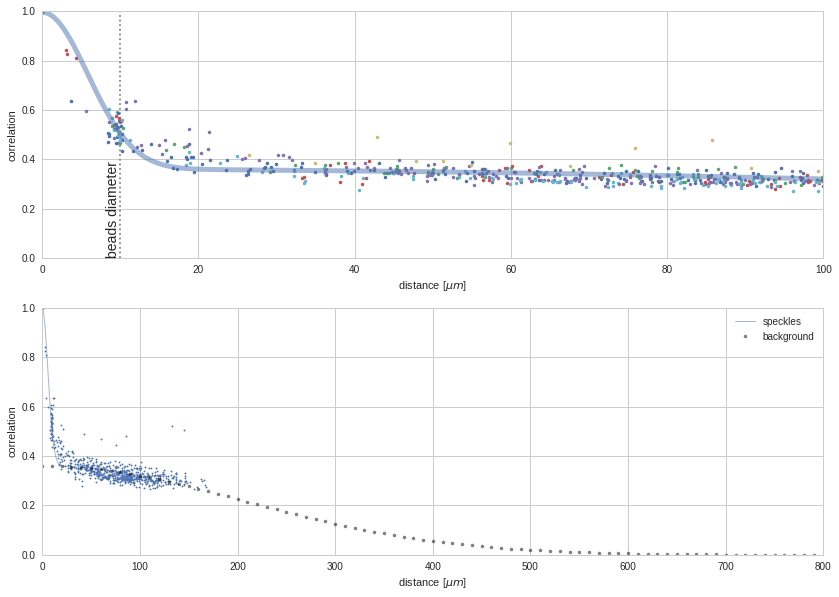

In [73]:
from scipy import optimize
import matplotlib 

import seaborn as sns
sns.set(color_codes=True)

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')

maxx = 100
maxxx = 800

fig = plt.figure(figsize=(14,10))
plt.subplot(211)

for idx, tmp in enumerate(vsdistance):
    tmp = np.array(tmp)
    plt.plot(tmp[:,0], tmp[:,1], '.')
    plt.xlabel(r'distance [$\mu m$]')
    plt.ylabel('correlation')

alldata = np.concatenate(vsdistance, axis=0)
fitfunc = lambda p, x: p[0]*np.exp(-1*p[1]*x**2)+p[2]*np.exp(-1*p[3]*x**2)

errfunc = lambda p, x, y: fitfunc(p, x) - y
bgcc = lambda p, x: p[2]*np.exp(-1*p[3]*x**2)
p0 = [0.65, 0.25, 0.1, 0.01]
p1, success= optimize.leastsq(errfunc, p0[:], args=(alldata[:, 0], alldata[:, 1]))

ccrad = np.sqrt(1/p1[1])*2.35*0.5
ccbgrad = np.sqrt(1/p1[3])*2.35*0.5
print(ccrad, ccbgrad)

xxx = np.arange(0,maxx, 0.5)

plt.plot(xxx, fitfunc(p1, xxx), linewidth=5, alpha=0.5, label='speckles')
# plt.plot(xxx, bgcc(p1, xxx), linewidth=1, alpha=0.5, label='background')

plt.vlines(10, 0, 1, colors='grey', linestyles='dotted')
plt.text(10,0,'beads diameter', size=14, ha="right", va="bottom", rotation=90)
# plt.hlines(p1[0], 0, maxx, colors='g', label='background correlation', linestyles='dotted')
plt.xlim([0, maxx])
plt.ylim([0, 1])
# plt.legend()

plt.subplot(212)
plt.scatter(alldata[:, 0], alldata[:, 1], s=2)
plt.plot(xxx, fitfunc(p1, xxx), linewidth=1, alpha=0.5, label='speckles')
xxxx = np.arange(0,maxxx, 10)
plt.plot(xxxx, bgcc(p1, xxxx), '.', color='black', linewidth=1, alpha=0.5, label='background')
# plt.plot(xxx, bgcc(p1, xxx), linewidth=1, alpha=0.5, label='background')
plt.xlabel(r'distance [$\mu m$]')
plt.ylabel('correlation')
plt.xlim([0, maxxx])
plt.ylim([0, 1])
plt.legend()

plt.show()
fig.savefig(rootff+'/ME_beads_supp.eps', dpi=300)

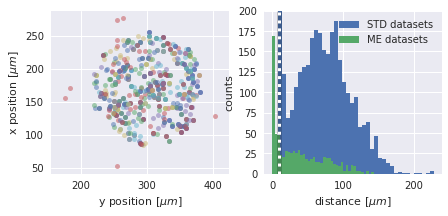

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


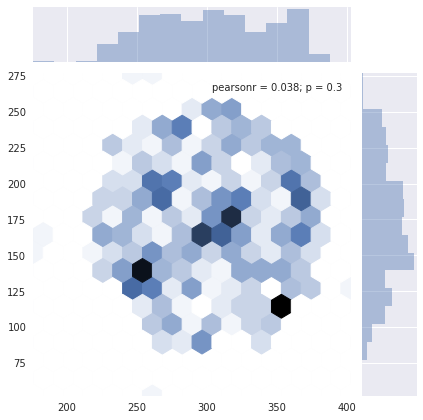

In [69]:
# plot the two inset with histogram of distances and scatterplot of location

import seaborn as sns
sns.set(color_codes=True)


vsdistance = []
dists = []
xxx = []
yyy = []

plt.figure(figsize=(7, 3))
plt.subplot(121)

for iii, seed in enumerate(seeds):
#     print(seed)
    pointlist = rootfolder+os.sep+seed+'_spots.csv'
    points = np.loadtxt(pointlist, delimiter=',') 
    dslen = len(points)
    for idx1 in range(dslen):
        for idx2 in range(idx1, dslen):
            dists = np.append(dists, np.linalg.norm(points[idx1][0]-points[idx2][0])*pxum) 
    plt.plot(points[:,0]*pxum, points[:,1]*pxum, 'o', markersize=5, alpha=0.5)
    xxx = np.append(xxx, points[:,0]*pxum, axis=0)
    yyy = np.append(yyy, points[:,1]*pxum, axis=0)

arootfolder = rootff
afolders = ['25012019', '04042019']
afolders = [rootfolder+ff for ff in folders]
adists = []
for fold in [arootfolder+fold for fold in os.listdir(arootfolder) if os.path.isdir(arootfolder+fold)]:
    for file in os.listdir(fold):
        if (file[-9:]=='spots.csv'):
            csvfile = fold+os.sep+file
            fpos = np.genfromtxt(csvfile, delimiter=',')
            beadsno = np.shape(fpos)[0]
            for i in range(beadsno):
                for j in range(i+1, beadsno):
                    adists = np.append(adists, np.linalg.norm(fpos[i]-fpos[j])*pxum)
            plt.plot(fpos[:,0]*pxum, fpos[:,1]*pxum, 'o', markersize=5, alpha=0.5)
            xxx = np.append(xxx, fpos[:,0]*pxum, axis=0)
            yyy = np.append(yyy, fpos[:,1]*pxum, axis=0)

# sns.jointplot(x=np.array(xxx), y=np.array(yyy), kind="hex", color="k");


plt.xlabel(r'y position [$\mu m$]')  
plt.ylabel(r'x position [$\mu m$]')
plt.axis('equal')
plt.subplot(122)
plt.hist(adists, 40, alpha=1, label='STD datasets')
plt.hist(dists, 40, alpha=1, label='ME datasets')
plt.legend(loc='upper right')
plt.vlines(10,0,200, color='black', lw=5, alpha=0.2)
plt.vlines(10,0,200, linestyles='dotted', color='white', lw=3)
plt.xlabel(r'distance [$\mu m$]')
plt.ylabel('counts')
plt.ylim([0,200])
plt.savefig(rootff+'/distances_fig2_supp.eps', dpi=300)
plt.show()

sns.jointplot(x=xxx, y=yyy, kind="hex")

In [84]:
# search the data in a particular range and representative ones, then average the crosscorrelation image
# (pixel sixe, setup dependent)
pxum = 6.5/(10*(200/180))

import seaborn as sns

def peckleccorrimg(sp1, sp2):
    return (ccorr(sp1, sp2)**2)/(np.max(ccorr(sp1, sp1))*np.max(ccorr(sp2, sp2)))

imagesize = np.shape(imread(rootfolder+os.sep+seeds[0]+'_speckle.tiff'))

ranges = [[0,5], [5,10], [10,20], [30, 50]]
# ranges = [[30,50]]

cclist = []

percentage = 0.8

overallindex = 0
for iii, seed in enumerate(seeds):
    speklepats = rootfolder+os.sep+seed+'_speckle.tiff'
    spekles = imread(speklepats)
    pointlist = rootfolder+os.sep+seed+'_spots.csv'
    points = np.loadtxt(pointlist, delimiter=',')
    dslen = len(points)
    
    for idx1 in range(dslen):
        for idx2 in range(idx1, dslen):
            for idx, rr in enumerate(ranges):
                if (alldata[overallindex][0]>0 and alldata[overallindex][1]>0.9):
                    print(seed)
                if ( (rr[0] < alldata[overallindex][0] < rr[1]) and (np.random.rand()<percentage) ):
                    print(f'{idx1} {idx2}')
                    title = r'range %d-%d, distance %.2f$\mu m$'%(rr[0], rr[1], alldata[overallindex][0])
                    print(title)
                    sp1 = spkstf.gauss_don_filt(matrix=spekles[idx1], lp=100, hp=5)
                    sp2 = spkstf.gauss_don_filt(matrix=spekles[idx2], lp=100, hp=5)
                    ccimg = peckleccorrimg(sp1, sp2)
                    
                    shift = -np.int16(np.unravel_index(np.argmax(ccimg, axis=None), ccimg.shape) - np.divide(ccimg.shape, 2))
                    ccimg = shiftimg(ccimg, shift=shift)
                    # still to understand from where was coming the wrong data formatting, but let's go on on today...
                    if np.shape(ccimg) == (2160,2560):
                        cclist.append([ccimg, alldata[overallindex][0]])
                        
            overallindex = overallindex+1

    

0 1
range 30-50, distance 33.23$\mu m$
0 6
range 30-50, distance 34.97$\mu m$
0 9
range 5-10, distance 9.51$\mu m$
0 12
range 10-20, distance 16.54$\mu m$
1 6
range 30-50, distance 33.10$\mu m$
2 3
range 10-20, distance 12.72$\mu m$
6 10
range 5-10, distance 8.60$\mu m$
6 11
range 10-20, distance 11.59$\mu m$
6 12
range 10-20, distance 18.51$\mu m$
10 11
range 5-10, distance 9.90$\mu m$
11 12
range 10-20, distance 15.94$\mu m$
0 5
range 30-50, distance 37.83$\mu m$
1 5
range 30-50, distance 36.25$\mu m$
2 5
range 30-50, distance 45.38$\mu m$
2 6
range 30-50, distance 49.33$\mu m$
0 1
range 30-50, distance 41.81$\mu m$
0 9
range 0-5, distance 4.31$\mu m$
1 6
range 30-50, distance 38.73$\mu m$
1 9
range 30-50, distance 45.73$\mu m$
2 4
range 0-5, distance 3.21$\mu m$
5 7
range 30-50, distance 33.48$\mu m$
5 10
range 5-10, distance 9.16$\mu m$
6 8
range 0-5, distance 3.05$\mu m$
7 10
range 30-50, distance 40.93$\mu m$
7 11
range 30-50, distance 33.32$\mu m$
10 11
range 5-10, distance 9.45

(2160, 2560)
(2160, 2560)
(2160, 2560)
(2160, 2560)


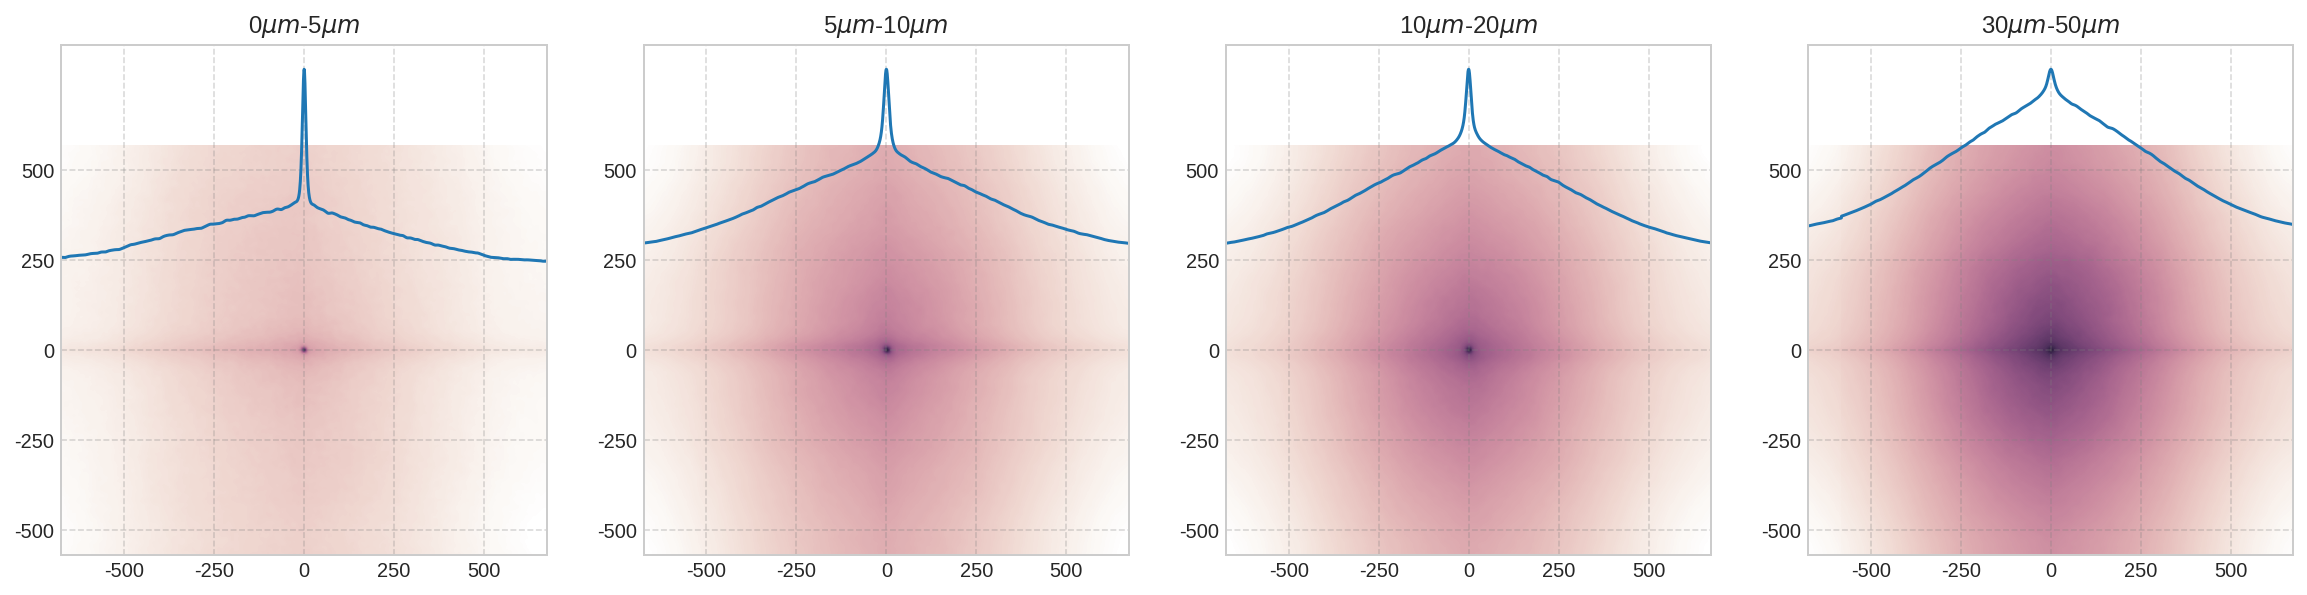

In [85]:
def plot_nice_figandprofile(ax, img, title, axticks=True):
#     ax.autoscale(enable=True, tight=True)
    ax.set_title(title)
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    ax.imshow(img, cmap=cmap, origin='lower')
    center = np.int16(np.unravel_index(np.argmax(img, axis=None), img.shape))
    shift = center - np.divide(img.shape, 2)
    step = 250/pxum
    xticksp = np.arange(center[1]-2*step,center[1]+2*step+step, step)
    xticks = ['%d'%(t*pxum) for t in np.arange(-2*step,2*step+step, step)]
    yticksp = np.arange(center[0]-2*step,center[0]+2*step+step, step)
    yticks = ['%d'%(t*pxum) for t in np.arange(-2*step,2*step+step, step)]
    if axticks:
        ax.set_yticks(yticksp)
        ax.set_yticklabels(yticks)
        ax.set_xticks(xticksp)
        ax.set_xticklabels(xticks)
    else:
        ax.set_yticks([])
        ax.set_xticks([])
    ax.grid(alpha=0.3, linestyle='--', color='grey')
    
    ax.plot(img[int(np.shape(img)[0]/2), :]\
            *(np.shape(img)[1]/(2*np.max(img)))+np.shape(img)[1]/2 )

fig = plt.figure(figsize=(len(ranges)*5, 5))
    
for idx, rr in enumerate(ranges):
    title = f'{rr[0]}$\mu m$-{rr[1]}$\mu m$'
    img = np.mean([data[0] for data in cclist if rr[0]<data[1]<rr[1]], axis=0)
    print(np.shape(img))
    img = crop(img, 0.9)
    ax = fig.add_subplot(1, len(ranges), idx+1)
    plot_nice_figandprofile(ax, img, title)

plt.show()

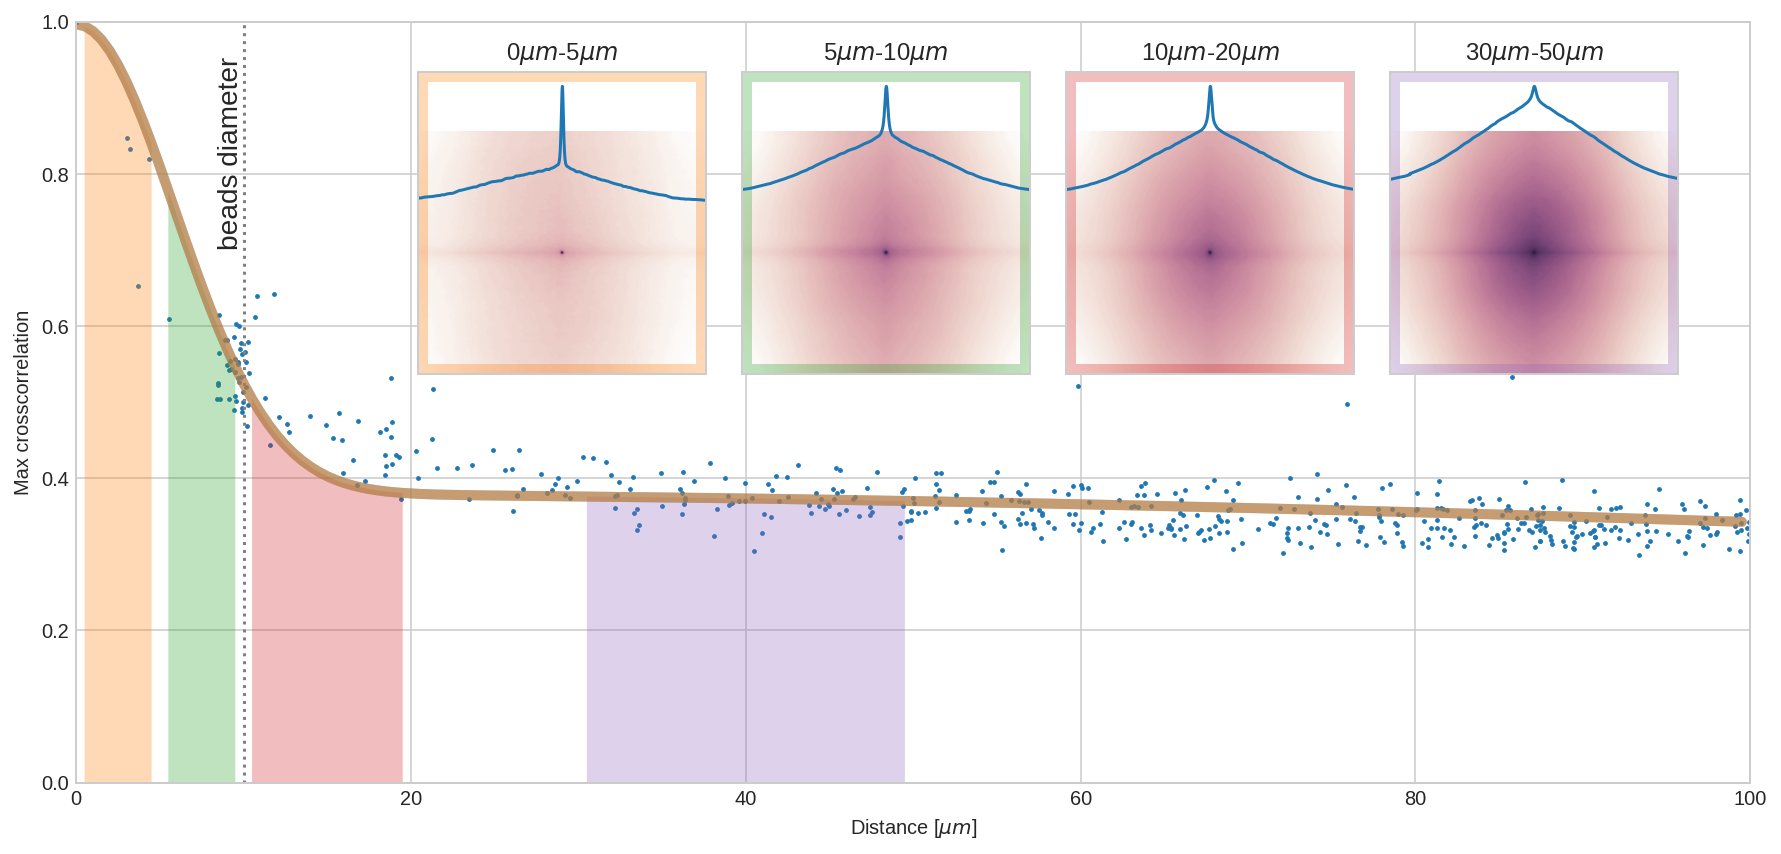

In [88]:
xxx = np.arange(0,maxx, 0.5)

fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(111)

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')

maxx = 100
maxxx = 800

xxx = np.arange(0,maxx, 0.5)
ax.plot(xxx, fitfunc(p1, xxx), linewidth=5, alpha=0.5, label='speckles')
ax.vlines(10, 0, 1, colors='grey', linestyles='dotted')
ax.text(10, 0.7,'beads diameter', size=14, ha="right", va="bottom", rotation=90)
ax.set_xlim([0, maxx])
ax.set_ylim([0, 1])
ax.scatter(alldata[:, 0], alldata[:, 1], s=2)

alldata = np.concatenate(vsdistance, axis=0)

ccrad = np.sqrt(1/p1[1])*2.35*0.5
ccbgrad = np.sqrt(1/p1[3])*2.35*0.5

from matplotlib.patches import Rectangle

for idx, rr in enumerate(ranges):
    acfilling = ax.fill_between(xxx, 0, fitfunc(p1, xxx), where=np.logical_and(rr[0]<xxx, xxx<rr[1]), alpha=0.3)
    # draw the inset
    axin = plt.axes([idx*0.15+0.2, 0.53, .3, .3])
    title = f'{rr[0]}$\mu m$-{rr[1]}$\mu m$'
    img = np.mean([data[0] for data in cclist if rr[0]<data[1]<rr[1]], axis=0)
    img = crop(img, 0.9)
    plot_nice_figandprofile(axin, img, title, axticks=False)
    r = Rectangle((0, 0), 1, 1,\
                  edgecolor=acfilling.get_facecolor()[0][:-1],\
                  alpha=acfilling.get_facecolor()[0][-1],\
                  facecolor='none', transform=axin.transAxes, linewidth=10)
    axin.add_patch(r)

xxx = np.arange(0,maxx, 0.5)
ax.plot(xxx, fitfunc(p1, xxx), linewidth=5, alpha=0.5, label='speckles')
ax.set_xlabel(r'Distance [$\mu m$]')
ax.set_ylabel('Max crosscorrelation')

plt.show()
%config InlineBackend.figure_format = 'retina'

ax.figure.savefig(rootff+'/crosscorr_dist.png', dpi=300, transparent=True)